In [1]:
import os
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from IPython.display import display, HTML

## Create regression table

In [2]:
source_path = '../../../fb_2022'

In [3]:
var = pd.read_csv(os.path.join(source_path, 'fb_2022_adid_var_sets_072124.csv.gz'))

/tmp/ipykernel_4095/1101205232.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  var = pd.read_csv(os.path.join(source_path, 'fb_2022_adid_var_sets_072124.csv.gz'))


In [4]:
'''
Filter for Set 3
'''
var = var[var.set3 == 1]

In [5]:
var.shape

(123991, 73)

### Import average text similarity results

In [6]:
'''
fed candidate campaign sponsors
'''
df_cand = pd.read_csv('../output_data/fb_set3_cand_pdid_media_average_pairwise_similarity.csv')

'''''
non-campaign sponsors
'''''
df_noncand = pd.read_csv('../output_data/fb_set3_noncandidate_pdid_racefocus_media_average_pairwise_similarity.csv')

In [7]:
print(df_noncand.columns)
df_noncand.head(2)

Index(['pd_id', 'race_of_focus', 'wmp_media_type', 'cid', 'num_unique', 'avg',
       'std'],
      dtype='object')


,pd_id,race_of_focus,wmp_media_type,cid,num_unique,avg,std
0,pd-100053898949-2,CA11,image,cid_127823 cid_66514,2,0.689309,0.000000
1,pd-100053898949-2,MT01,video,cid_153207 cid_153208 cid_153209 cid_153210,4,0.895821,0.034215


In [8]:
'''
Select only relevant sponsors from set3 var table
'''
all_sponsor_ids = df_cand.pd_id.tolist() + df_noncand.pd_id.tolist()
var = var[var.pd_id.isin(all_sponsor_ids)]

### Process/explore variables

**Party variables**

Check percentage of sponsors for whom we have to infer party 

In [9]:
# 7% ads
print(var[pd.isna(var.party_all)].shape[0]/var.shape[0])

0.07295933448756386


In [10]:
# 28% sponsors
len(var[pd.isna(var.party_all)].groupby('pd_id')[['party_all']].first().reset_index().pd_id.unique())/len(var.pd_id.unique())

0.2840396753832281

In [11]:
len(var[pd.isna(var.party_all)].groupby('pd_id')[['party_all']].first().reset_index().pd_id.unique())

630

In [12]:
len(var.pd_id.unique())

2218

In [13]:
# calculate party classifier accuracy, pd_id level
confusion_mat_tab = var[['pd_id', 'party_all', 'party_all_clf_pdid']].groupby('pd_id').first().reset_index()

In [14]:
pd.crosstab(confusion_mat_tab.party_all, confusion_mat_tab.party_all_clf_pdid)

party_all_clf_pdid,DEM,OTHER,REP
party_all,,,
DEM,525,0,68
MISSING,303,0,179
OTHER,24,2,11
REP,75,0,401


In [15]:
'''
Create "optimized" party var
1) Use party variables from entity files. 
2) When they are not available, use pd_id level party classifier's predictions 
'''

var['party_pdid_opt'] = np.where(pd.isna(var.party_all), var.party_all_clf_pdid, var.party_all)

**Race competitiveness**: 

SD: safe Dem
DF: Dem favored
LD: Lean Dem
C: Too-close-to-call
LR: Lean Republican
RF: Republican favored
SR: Safe Republican
 
The SD and SR races are coded 1 in house2 (least competitive)
DF and RF are coded 2
LD and LR are coded 3
C is coded 4 (most competitive)

In [16]:
# load race competitiveness index file
race = pd.read_csv('../../race_competitiveness.csv')

In [17]:
var = var.merge(race[['race_code','race_competitiveness']], how='left', left_on='race_of_focus', right_on='race_code')

In [18]:
var.race_competitiveness

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
94719    NaN
94720    NaN
94721    NaN
94722    NaN
94723    1.0
Name: race_competitiveness, Length: 94724, dtype: float64

**If we were to group non-campaign sponsor types by their race of focus (to use the new DV):**

In [51]:
# var.wmp_spontype.unique() # remove nan

array(['government agency', 'group', nan, 'government official',
       'campaign', 'party national', 'party'], dtype=object)

In [53]:
# grouped = var[var.wmp_spontype != 'campaign'].groupby(["pd_id", "wmp_spontype", "race_of_focus"]).size().reset_index()
# grouped.rename(columns={0:'race_count'}, inplace=True)

In [56]:
# grouped.wmp_spontype.unique()

array(['party', 'group', 'government official', 'party national',
       'coordinated', 'government agency'], dtype=object)

**campaign resources**

Only for the subset of sponsors who invested in TV ads

In [19]:
cost = pd.read_csv('../input_data/campaign_resource_fb2022.csv')

In [20]:
'''
Merge to regression tables
'''

df_cand = df_cand.merge(cost[['pd_id', 'estcost']], on='pd_id', how='left')
df_noncand = df_noncand.merge(cost[['pd_id', 'estcost']], on='pd_id', how='left')

In [21]:
# Log transform
df_cand['estcost'] = np.log(df_cand['estcost'])
df_noncand['estcost'] = np.log(df_noncand['estcost'])

In [22]:
df_cand.rename(columns={"estcost":"log_estimated_cost"}, inplace=True)
df_noncand.rename(columns={"estcost":"log_estimated_cost"}, inplace=True)

### Select regression variables

In [23]:
cols = ['pd_id', 'wmp_media_type', 'wmp_office', 'wmp_spontype', 'party_pdid_opt', 
        'race_of_focus', 'race_competitiveness', ]

In [24]:
data = var[cols]

In [25]:
data.head(2)

,pd_id,wmp_media_type,wmp_office,wmp_spontype,party_pdid_opt,race_of_focus,race_competitiveness
0,pd-105355871121994-2,video,NaN,government agency,MISSING,FL08,1.0
1,pd-105355871121994-2,video,NaN,government agency,MISSING,FL08,1.0


In [26]:
# FB/Insta don't have text ads
df_cand.wmp_media_type.unique()

array(['image', 'video', 'image, video'], dtype=object)

In [27]:
data.wmp_office.unique()

array([nan, 'us house', 'us senate',
       'us house - not in our 2022 FEC cd file'], dtype=object)

### Process regression variables

In [29]:
data['image'] = np.where((data.wmp_media_type == 'image'), 1, 0)

data['party'] = np.where(data.wmp_spontype.isin(['party', 'party national']), 1, 0)
data['group'] = np.where(data.wmp_spontype == 'group', 1, 0)
data['other_sponsor_type'] = np.where(data.wmp_spontype.isin(['government official',
                                                              'coordinated', 'government agency',]), 1, 0)

data['Democratic'] = np.where(data.party_pdid_opt == 'DEM', 1, 0)
data['third_party'] = np.where(data.party_pdid_opt == 'OTHER', 1, 0)

# Senate races
data['senate'] = np.where((data.wmp_office == 'us senate') | (data.race_of_focus.str.endswith('S0')), 1, 0)

/tmp/ipykernel_4095/1168873442.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['image'] = np.where((data.wmp_media_type == 'image'), 1, 0)
/tmp/ipykernel_4095/1168873442.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['party'] = np.where(data.wmp_spontype.isin(['party', 'party national']), 1, 0)
/tmp/ipykernel_4095/1168873442.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [34]:
# aggregate at the advertiser level
agg = data.groupby(['pd_id', 'wmp_media_type']).mean(numeric_only=True).reset_index()

### Candidate regression table

In [35]:
df_cand = df_cand.merge(agg, on=['pd_id', 'wmp_media_type'], how='left')

In [36]:
df_cand.rename(columns={'avg': 'AverageSimilarity'}, inplace=True)

In [37]:
df_cand['candidate'] = 1

In [38]:
df_cand.columns

Index(['pd_id', 'wmp_media_type', 'cid', 'num_unique', 'AverageSimilarity',
       'std', 'log_estimated_cost', 'race_competitiveness', 'image', 'party',
       'group', 'other_sponsor_type', 'Democratic', 'third_party', 'senate',
       'candidate'],
      dtype='object')

In [39]:
df_cand.shape

(1017, 16)

### Non-candidate regression table

In [40]:
'''
for non-candidate, non-campaign sponsors

to merge with df_noncand 
'''
agg2 = data.groupby(['pd_id', 'wmp_media_type', 'race_of_focus']).mean(numeric_only=True).reset_index()

In [44]:
agg2.columns

Index(['pd_id', 'wmp_media_type', 'race_of_focus', 'race_competitiveness',
       'image', 'party', 'group', 'other_sponsor_type', 'Democratic',
       'third_party', 'senate'],
      dtype='object')

In [45]:
df_noncand = df_noncand.merge(agg2, on=['pd_id', 'wmp_media_type', 'race_of_focus'], how='left')

df_noncand.rename(columns={'avg': 'AverageSimilarity'}, inplace=True)

In [46]:
df_noncand['candidate'] = 0

In [47]:
print(df_noncand.shape)
df_noncand.columns

(3482, 17)


Index(['pd_id', 'race_of_focus', 'wmp_media_type', 'cid', 'num_unique',
       'AverageSimilarity', 'std', 'log_estimated_cost',
       'race_competitiveness', 'image', 'party', 'group', 'other_sponsor_type',
       'Democratic', 'third_party', 'senate', 'candidate'],
      dtype='object')

### Combine candidates only and non-candidates sponsors grouped by race of focus

In [49]:
df_cand.shape

(1017, 16)

In [50]:
df = pd.concat([df_cand, df_noncand.drop("race_of_focus", axis=1)])

In [51]:
df.columns

Index(['pd_id', 'wmp_media_type', 'cid', 'num_unique', 'AverageSimilarity',
       'std', 'log_estimated_cost', 'race_competitiveness', 'image', 'party',
       'group', 'other_sponsor_type', 'Democratic', 'third_party', 'senate',
       'candidate'],
      dtype='object')

In [52]:
'''
Final regression table
'''
df.to_csv('../input_data/fb_regression_table_for_descriptives.csv', index=False)

### Import regression table directly

In [5]:
df = pd.read_csv('../input_data/fb_regression_table_for_descriptives.csv')

In [54]:
df.shape

(4499, 16)

In [6]:
df_cand = df[df.candidate == 1]

### Subset of sponsors who invested in TV ads

In [7]:
df_cost = df[~pd.isna(df.log_estimated_cost)]

In [8]:
print(df.shape)
print(df_cost.shape)

(4499, 16)
(593, 16)


In [9]:
df_cand_cost = df_cost[(df_cost.candidate == 1)]

In [10]:
df_cand_cost.shape

(537, 16)

## Create DV (new method)

In [11]:
def create_sophistication_index(input_df):
    max_ = input_df.num_unique.max()
    min_ = input_df.num_unique.min()
    input_df['num_unique_normalized'] = (input_df.num_unique - min_)/(max_ - min_)
    input_df['sophistication_index'] = input_df['num_unique_normalized'] * (1 - input_df.AverageSimilarity)
    return input_df

In [12]:
df = create_sophistication_index(df)

In [13]:
df_cand = create_sophistication_index(df_cand)
df_cost = create_sophistication_index(df_cost)
df_cand_cost = create_sophistication_index(df_cand_cost)

/tmp/ipykernel_25918/1499460830.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['num_unique_normalized'] = (input_df.num_unique - min_)/(max_ - min_)
/tmp/ipykernel_25918/1499460830.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['sophistication_index'] = input_df['num_unique_normalized'] * (1 - input_df.AverageSimilarity)
/tmp/ipykernel_25918/1499460830.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

## Regression

In [4]:
import statsmodels.api as sm

### New DV

In [31]:
rename_labels = {'senate': 'Senate', 'race_competitiveness': 'Race competitiveness', 
                  'third_party': 'Third party', 'image': 'Image',
                 'log_estimated_cost': 'TV ad spending (logged)', 
                 'party': 'Party', 'group': 'Group', 
                 'other_sponsor_type': 'Other sponsor type'}

In [184]:
# for house/senate candidates only 
form1 = "sophistication_index ~ senate + race_competitiveness \
        + Democratic + third_party + image"

form2 = "sophistication_index ~ senate + race_competitiveness \
        + Democratic + third_party + log_estimated_cost \
        + image"

model1 = smf.ols(formula=form1, data=df_cand).fit()
model2 = smf.ols(formula=form2, data=df_cand_cost).fit()

In [185]:
# DV Sophistication index, Candidates Only
cov_order = ['senate', 'race_competitiveness',
             'Democratic', 'third_party', 'log_estimated_cost', 
             'image', 'Intercept'] 

stargazer = Stargazer([model1, model2])
stargazer.covariate_order(cov_order)
stargazer.rename_covariates(rename_labels)
display(HTML(stargazer.render_html()))

In [186]:
# for all sponsors, non-campaign sponsors grouped by race 
form3 = "sophistication_index ~ senate + party + group + other_sponsor_type + race_competitiveness \
        + Democratic + third_party + image"

form4 = "sophistication_index ~ senate + party + group + other_sponsor_type + race_competitiveness \
        + Democratic + third_party + log_estimated_cost \
        + image"

model3 = smf.ols(formula=form3, data=df).fit()
model4 = smf.ols(formula=form4, data=df_cost).fit()

In [187]:
# DV Sophistication index, Candidates + non-candidates grouped by race of focus
cov_order = ['senate', 'party', 'group', 'other_sponsor_type', 'race_competitiveness',
             'Democratic', 'third_party', 'log_estimated_cost', 
             'image', 'Intercept'] 

stargazer = Stargazer([model3, model4])
stargazer.covariate_order(cov_order)
stargazer.rename_covariates(rename_labels)
display(HTML(stargazer.render_html()))

### Diagnostic plots

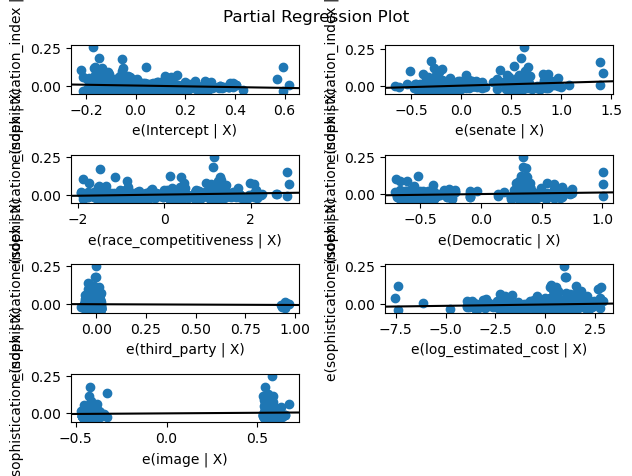

In [101]:
fig = sm.graphics.plot_partregress_grid(model2)
fig.tight_layout(pad=1.0)

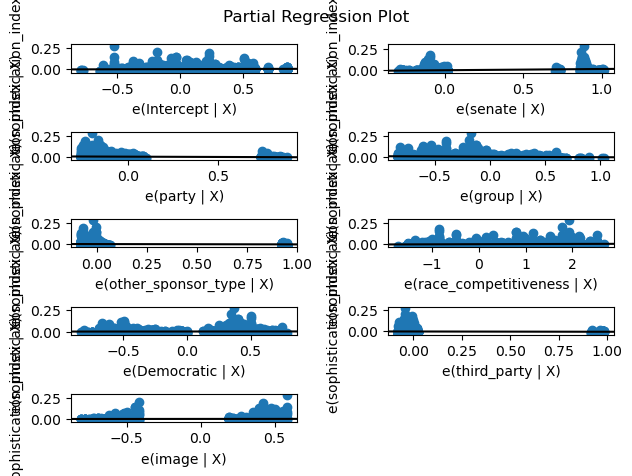

In [105]:
fig = sm.graphics.plot_partregress_grid(model1)
fig.tight_layout(pad=1.0)

## Main effects plots

In [244]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

In [222]:
coefficients1 = model1.params
conf1 = model1.conf_int()
conf1['coef'] = coefficients1
conf1.columns = ['lower', 'upper', 'coef']
conf1['model'] = 'Model 1'

coefficients2 = model2.params
conf2 = model2.conf_int()
conf2['coef'] = coefficients2
conf2.columns = ['lower', 'upper', 'coef']
conf2['model'] = 'Model 2'

In [223]:
conf12 = pd.concat([conf1, conf2])
conf12.rename(index=rename_labels, inplace=True)
conf12 = conf12[conf12.index != 'Intercept']

In [225]:
# Add offset to separate the models
offset = -0.15
conf12['y_offset'] = conf12.groupby(conf12.index).cumcount() * offset

In [226]:
conf12.index.unique()[::-1]

Index(['TV ad spending (logged)', 'Image', 'Third party', 'Democratic',
       'Race competitiveness', 'Senate'],
      dtype='object')

In [227]:
conf12.index.map(y_steps)

Int64Index([5, 4, 3, 2, 1, 5, 4, 3, 2, 0, 1], dtype='int64')

In [228]:
labels = list(conf12.index.unique()[::-1])
labels

['TV ad spending (logged)',
 'Image',
 'Third party',
 'Democratic',
 'Race competitiveness',
 'Senate']

In [229]:
y_steps = {}
for i, label in enumerate(labels):
    y_steps[label] = i

y_steps

{'TV ad spending (logged)': 0,
 'Image': 1,
 'Third party': 2,
 'Democratic': 3,
 'Race competitiveness': 4,
 'Senate': 5}

In [230]:
conf12['y_step'] = conf12.index.map(y_steps)

<Figure size 1000x800 with 0 Axes>

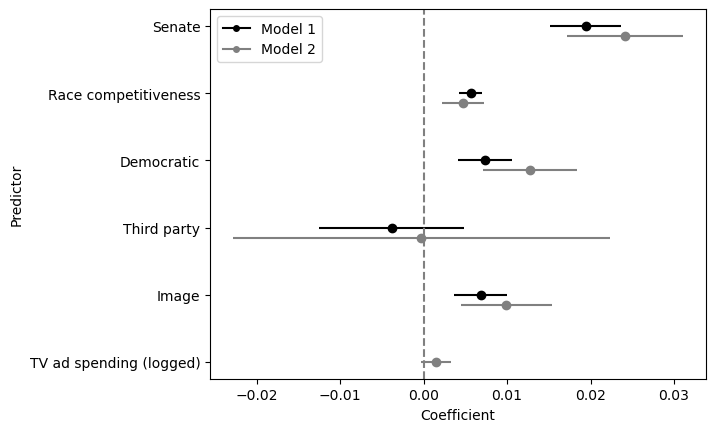

In [248]:
# Plotting
plt.figure(figsize=(10, 8))
fig, ax = plt.subplots()

colors=['black', 'gray']

for i, model in enumerate(conf12.model.unique()):
    curr_coef = conf12[conf12.model == model]
    ax.errorbar(y=curr_coef['y_offset'] + curr_coef['y_step'], 
                 x=curr_coef['coef'], 
                 xerr=(curr_coef['upper'] - curr_coef['lower']) / 2, 
                 fmt='o', 
                 color=colors[i])

    

# Create legend
handle1 = mlines.Line2D([], [], color='black', linestyle='-', marker='o', markersize=4, label='Model 1')
handle2 = mlines.Line2D([], [], color='gray', linestyle='-', marker='o', markersize=4, label='Model 2')
ax.legend(handles=[handle1, handle2], loc='best')

# Format yticks labels and other labels
plt.yticks(ticks=range(len(labels)), labels=labels)
plt.title('')
plt.ylabel('Predictor')
plt.xlabel('Coefficient')
plt.axvline(0, color='grey', linestyle='--')
plt.show()


In [256]:
def plot_coefficents(m1, m2, offset=-0.15):
    '''
      Inputs: 
          m1, m2: two OLS regression models
    '''
    coefficients1 = m1.params
    conf1 = m1.conf_int()
    conf1['coef'] = coefficients1
    conf1.columns = ['lower', 'upper', 'coef']
    conf1['model'] = 'Model 1'

    coefficients2 = m2.params
    conf2 = m2.conf_int()
    conf2['coef'] = coefficients2
    conf2.columns = ['lower', 'upper', 'coef']
    conf2['model'] = 'Model 2'
    
    conf12 = pd.concat([conf1, conf2])
    conf12.rename(index=rename_labels, inplace=True)
    conf12 = conf12[conf12.index != 'Intercept']
    
    # Add offset to separate the models
    conf12['y_offset'] = conf12.groupby(conf12.index).cumcount() * offset
    
    labels = list(conf12.index.unique()[::-1])

    y_steps = {}
    for i, label in enumerate(labels):
        y_steps[label] = i

    conf12['y_step'] = conf12.index.map(y_steps)
    
    # Plotting
    plt.figure(figsize=(10, 8))
    fig, ax = plt.subplots()

    colors=['black', 'gray']

    for i, model in enumerate(conf12.model.unique()):
        curr_coef = conf12[conf12.model == model]
        ax.errorbar(y=curr_coef['y_offset'] + curr_coef['y_step'], 
                     x=curr_coef['coef'], 
                     xerr=(curr_coef['upper'] - curr_coef['lower']) / 2, 
                     fmt='o', 
                     color=colors[i])



    # Create legend
    handle1 = mlines.Line2D([], [], color='black', linestyle='-', marker='o', markersize=4, label='Model 1')
    handle2 = mlines.Line2D([], [], color='gray', linestyle='-', marker='o', markersize=4, label='Model 2')
    ax.legend(handles=[handle1, handle2], loc='best')

    # Format yticks labels and other labels
    plt.yticks(ticks=range(len(labels)), labels=labels)
    plt.title('')
    plt.ylabel('Predictor')
    plt.xlabel('Coefficient')
    plt.axvline(0, color='grey', linestyle='--')
    plt.show()

<Figure size 1000x800 with 0 Axes>

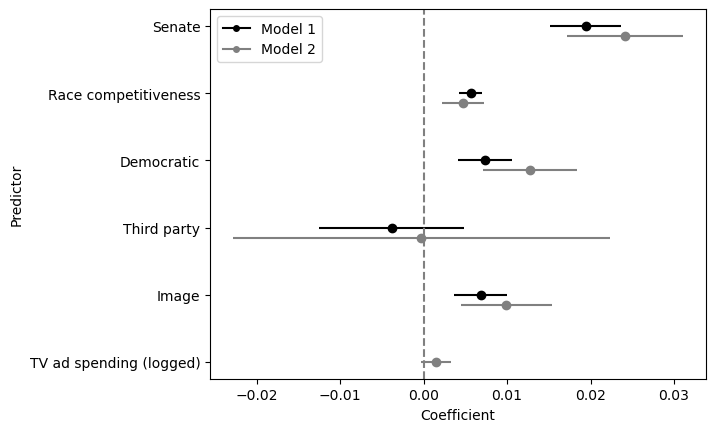

In [257]:
plot_coefficents(model1, model2)

<Figure size 1000x800 with 0 Axes>

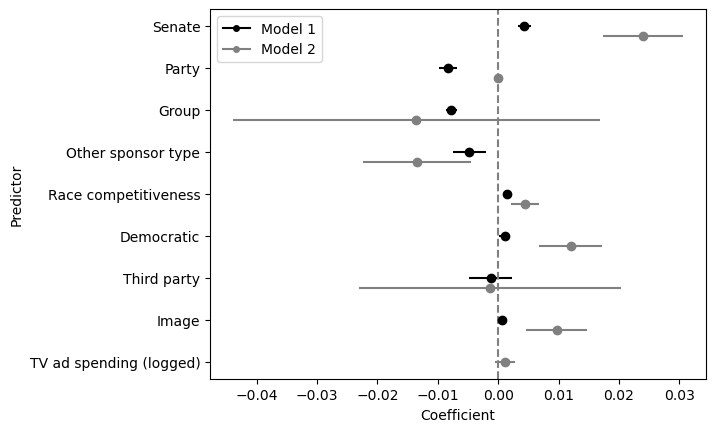

In [258]:
plot_coefficents(model3, model4,offset=-0.25)

**Legacy**

In [126]:
# for a single model
def plot_coefs(model, rename_dict, title=''):
    coefficients = model.params
    conf = model.conf_int()
    conf['coef'] = coefficients
    conf.columns = ['2.5%', '97.5%', 'coef']
    conf = conf.rename(index=rename_dict)
    conf = conf[conf.index != 'Intercept']
    
    # Plotting
    plt.figure(figsize=(8, 6))
    sns.pointplot(y=conf.index, x='coef', data=conf, join=False, ci=None, color='black')
    plt.errorbar(y=conf.index, x=conf['coef'], xerr=(conf['97.5%'] - conf['2.5%']) / 2, fmt='o', color='black')

    plt.title(title)
    plt.ylabel('Predictor')
    plt.xlabel('Coefficient')
    plt.axvline(0, color='grey', linestyle='--')
    plt.show()

/tmp/ipykernel_25073/3338089615.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(y=conf.index, x='coef', data=conf, join=False, ci=None, color='black')


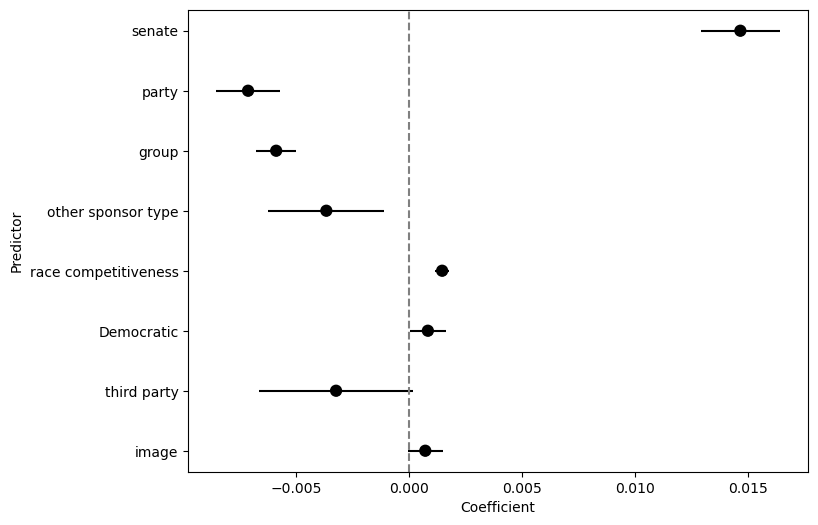

In [133]:
plot_coefs(model1, rename_labels)